# 18.S190/6.S090 Problem Set 4 Solutions

## Problem 1: Adaptive quadrature (10+10+10 points)

In this problem, you will compare h-adaptive quadrature with p-adaptive quadrature for the example integral:
$$
\int_0^{2\pi} \mathrm{Re}\left[\frac{1}{1 - (0.979 + 0.198i) e^{i\phi}}\right] d\phi = 2\pi
$$
(The analytical result $2\pi$ is obtained using the [residue theorem](https://en.wikipedia.org/wiki/Residue_theorem).)  If you plot this integrand, you should see that it has a very **sharp peak** near one end of the domain.

1. Implement "p-adaptive" quadrature where you integrate this function using an $N+1$-point Clenshaw–Curtis rule (using the code from pset 3), where you repeatedly double $N$, and plot the relative error vs. $N+1$ (the number of function evaluations) until the error reaches the limit of roundoff errors and stops improving.   Do the same thing for $N+1$ point trapezoidal rule, which should also converge exponentially fast since this integrand is periodic.  (Since these rules are nested, when you double $N$ you could re-use the previous function evaluations, but you don't need to implement this optimization.)

2. Implement "h-adaptive" quadrature using a fixed-order $N+1$ point Clenshaw–Curtis rule, for $N=16$:
    * Keep a list of sub-intervals $[a,b]$, starting with just a single interval $[0,2\pi]$, and estimated integral $I_N$ for each interval.
    * For each interval, also store an estimate of the error in $I_N$ by $|I_N - I_{N/2}|$, i.e. by comparing the nested $N=8$ Clenshaw–Curtis rule (which doesn't require any additional function evaluations).
    * **At each h-adaptive step:** Pick the interval with the *largest* error estimate, and break it in half into two subintervals.  Remove the interval from your list and replace it with these two subintervals, along with their estimated integrals and errors.  (A more efficient data structure for this sort of thing is a [priority queue](https://en.wikipedia.org/wiki/Priority_queue), but you don't need to worry about this.)
    * The estimated integral $I$ is just the sum of the integrals for each subinterval (and the estimated error is the sum of the estimated errors).   (In a real application, you would stop when the estimated error falls below some desired tolerance.)  Keep track of the actual relative error $|I - 2\pi|/2\pi$ after each step, as a function of the *total* number of function evaluations up to that point (including the evaluations for the intervals that were subdivided and discarded).   Plot this error vs. function evaluations (include it on the same plot as 1.1) … again, keep going until your error is close to machine precision.

3. Make a new plot with the same 3 curves as in parts 1.1 and 1.2, with the same algorithms, but for the integral $\int_0^{2\pi} 17.25 \cos(17.25\phi) d\phi = 1$, where the integrand is *not* sharply peaked.  (Clearly label all of your plots!)  What do you observe?

### Solutions

First, let's define a function for the integrand and plot it, to see the claimed sharp peak:

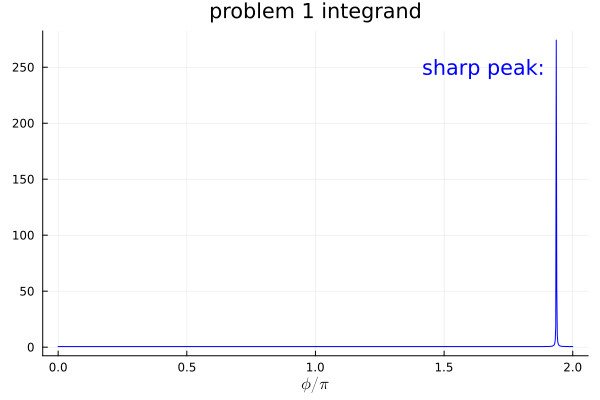

In [1]:
using Plots, LaTeXStrings

f1(ϕ) = real(inv(1 - (0.979 + 0.198im)*cis(ϕ)))
ϕs = range(0, 2π, length=1000)
plot(ϕs/π, f1.(ϕs), legend=false, title="problem 1 integrand",
     xlabel=L"\phi / \pi", linecolor=:blue)
annotate!(1.65, 250, ("sharp peak:", :blue))

In [2]:
# Julia code from pset 3 to get Clenshaw–Curtis points and weights:
import FFTW
function clenshaw_curtis(N)
    iseven(N) && N > 0 || throw(ArgumentError("this implementation requires even N > 0"))
    x = cos.(range(0, pi, length=N+1)) # Chebyshev points
    k = 0:N÷2
    d = @. 2 / (1-4k^2) # cosine integrals
    w = FFTW.r2r(d, FFTW.REDFT00) / N # type-I DCT
    w[1] /= 2
    return x, [w; reverse(w[1:end-1])]
end

clenshaw_curtis (generic function with 1 method)

**(1)** First, let's emulate p-adaptive quadrature in the most obvious way, just repeatedly doubling $N$, not bothering with the optimization of re-using the function evaluations from the previous $N$ even though the points are nested, both for Clenshaw–Curtis and the trapezoidal rule (or equivalently a Riemann sum, since the function is periodic)

In [3]:
relerr(val, exact) = abs(val - exact) / abs(exact)

Npow2 = 2 .^ (2:15)
errs_padaptive = map(Npow2) do N
    x, w = clenshaw_curtis(N)
    ϕ = @. (x + 1) * π   # map the domain from [-1,1] to [0,2π]
    relerr(sum(f1.(ϕ) .* w) * π, 2π)
end

errs_trapz = map(Npow2) do N
    ϕ = range(0, 2π, length=N+1) # N+1 equally spaced points
    # note that f1(0) = f1(2π), so we can combine the first and last points
    relerr(sum(f1, ϕ[1:N]) * (2π/N), 2π)
end;

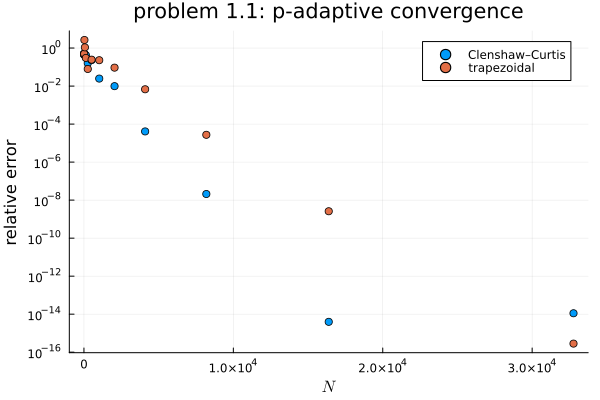

In [4]:
scatter(Npow2, errs_padaptive, label="Clenshaw–Curtis", 
        yaxis=:log10, yticks=exp10.(-16:2:0), title="problem 1.1: p-adaptive convergence",
        ylabel="relative error", xlabel=L"N")
scatter!(Npow2, errs_trapz, label="trapezoidal")

As expected, we get exponential convergence (nearly a straight line on a semilog scale), once $N$ is big enough, until we hit the limits of machine precision.

However, it is also instructive to plot this on a log–log scale (where it will *not* be a straight line), to see that $N$ needs to be $\gtrsim 1000$ before the exponential convergence sets in — we need to sample enough points to "see" the peak:

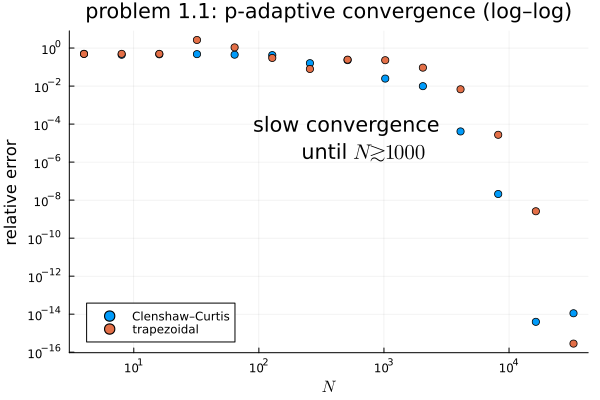

In [5]:
scatter(Npow2, errs_padaptive, label="Clenshaw–Curtis", 
        xaxis=:log10, xticks=exp10.(0:5),
        yaxis=:log10, yticks=exp10.(-16:2:0), title="problem 1.1: p-adaptive convergence (log–log)",
        ylabel="relative error", xlabel=L"N", legend=:bottomleft)
scatter!(Npow2, errs_trapz, label="trapezoidal")
annotate!(500, 1e-4, "slow convergence")
annotate!(700, 3e-6, L"until $N \gtrsim 1000$")

**(2)** Now, let's implement h-adaptive quadrature.   A few notes:

* We store a set of $(a,b,I,E)$ tuples of sub-segments $[a,b]$ and the corresponding integral estimate $I$ and error estimate $E$.
* At each step, we sub-divide the segment with the largest $E$.   To make this efficient, it is best to use a data structure called a [heap](https://en.wikipedia.org/wiki/Heap_(data_structure)) (from Julia's [DataStructures.jl package](https://juliacollections.github.io/DataStructures.jl/latest/).
* Clenshaw–Curtis rules are *not* ideal for h-adaptive quadrature because they include the endpoints $\pm 1$.  That means that adjacent sub-segments share points.  Avoiding repeated function evaluations would take a bunch of bookkeeping, which I don't want to do, so we just evaluate the shared endpoints twice.  In practice, it's nicer to implement h-adaptive quadrature using a [Gauss–Kronrod rule](https://en.wikipedia.org/wiki/Gauss%E2%80%93Kronrod_quadrature_formula), which does *not* include the endpoints.  (This also makes it easier to deal with endpoints where the integrand is singular.)

For plotting purposes, we also return an array of evaluation counts and corresponding error estimates (or exact errors if an `exact` argument is passed), updated after each subdivision, and we also return a list of evaluation points on the final set of intervals.

In [6]:
# evaluate the quadrature rule (x,w) for f on [a,b]
# and return a named tuple of the estimated integral I
# and the estimated error from the nested rule (x[1:2:end], w2)
# (every other point of x).
function evalrule(f, a, b, x, w, w2)
    jacobian = (b - a)/2
    # a faster implementation would avoid allocating/storing
    # any array of function values, summing in-place, but
    # let's keep the code simple:
    fx = @. f((x + 1) * jacobian + a)
    I = sum(w .* fx) * jacobian
    I2 = sum(w2 .* fx[1:2:end]) * jacobian
    return (I=I, E=abs(I - I2)) # return I and error estimate E
end

using DataStructures: BinaryHeap

function hadaptive(f, a_, b_; orderN=16, rtol=1e-8, maxevals=10^6, exact=nothing)
    a, b = promote(float(a_), float(b_)) # promote a,b to common floating-point type
    
    x, w = clenshaw_curtis(orderN)
    x2, w2 = clenshaw_curtis(orderN ÷ 2) # nested rule
    @assert x2 ≈ x[1:2:end] # nested rule should just be every other x

    # evaluate initial (a,b) segment and push it to a heap ordered by E:
    seg = (a=a, b=b, evalrule(f, a, b, x, w, w2)...) # (a,b,I,E) in a named tuple
    segs = BinaryHeap(Base.Order.By(seg -> seg.E, Base.Order.Reverse), [seg])

    # keep subdividing until error tolerance or maxevals is reached:
    I, E = seg.I, seg.E
    evals = orderN+1
    errors, evaluations = [isnothing(exact) ? E : abs(I - exact)], [evals]
    while E ≥ rtol * abs(I) && evals < maxevals
        seg = pop!(segs) # remove element with largest error
        m = (seg.a + seg.b)/2 # halve at midpoint

        # create/evaluate 2 new segments (a,m) and (m,b) and push them to heap
        seg1 = (a=seg.a, b=m, evalrule(f, seg.a, m, x, w, w2)...)
        seg2 = (a=m, b=seg.b, evalrule(f, m, seg.b, x, w, w2)...)
        push!(segs, seg1)
        push!(segs, seg2)
        
        evals += 2*(orderN+1) # track function evaluation count

        # update integral and error estimates
        I += seg1.I + seg2.I - seg.I
        E += seg1.E + seg2.E - seg.E
        
        # save error history
        push!(evaluations, evals)
        push!(errors, isnothing(exact) ? E : abs(I - exact))
    end
    
    # for pedagogical purposes, also return the list of quadrature points
    # from the final set of intervals:
    quadpts = Float64[]
    for seg in segs.valtree
        append!(quadpts, (x .+ 1) .* (seg.b - seg.a)/2 .+ seg.a)
    end
    sort!(quadpts)
    
    return (; I, E, evals, evaluations, errors, quadpts)
end

hadaptive (generic function with 1 method)

Let's do a quick sanity check to that it is giving the right answer, before we plot convergence:

In [7]:
result = hadaptive(f1, 0, 2π, exact=2π)
println((; result.I, result.E, result.evals))
@show relerr(result.I, 2π)

(I = 6.283185307179491, E = 5.7570539238605e-8, evals = 799)
relerr(result.I, 2π) = 1.5125304485182056e-14


1.5125304485182056e-14

Hooray, it got the right answer to nearly machine precision with only 799 evaluations.  (This is the case even though we set a relative tolerance of `rtol = 1e-8`, because the error estimation is generally quite conservative for smooth functions.)

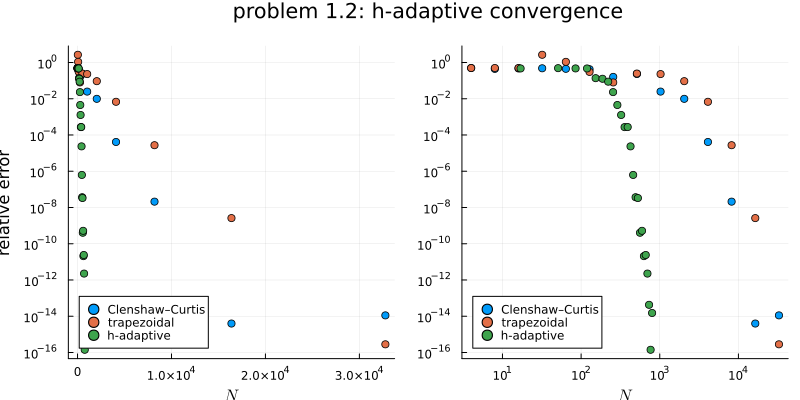

In [8]:
title = plot(title = "problem 1.2: h-adaptive convergence", 
             grid = false, showaxis = false, bottom_margin = -50Plots.px)

p2 = scatter(Npow2, errs_padaptive, label="Clenshaw–Curtis", 
        yaxis=:log10, yticks=exp10.(-16:2:0),
        ylabel="relative error", xlabel=L"N", legend=:bottomleft)
scatter!(p2, Npow2, errs_trapz, label="trapezoidal")
scatter!(p2, result.evaluations, result.errors / 2π, label="h-adaptive")

p1 = scatter(Npow2, errs_padaptive, label="Clenshaw–Curtis", 
        xaxis=:log10, xticks=exp10.(0:5),
        yaxis=:log10, yticks=exp10.(-16:2:0),
        xlabel=L"N", legend=:bottomleft)
scatter!(p1, Npow2, errs_trapz, label="trapezoidal")
scatter!(p1, result.evaluations, result.errors / 2π, label="h-adaptive")

plot(title, p2, p1, layout = @layout([A{0.1h}; [B C]]), size=(800,400))

The h-adaptive convergence *looks* exponential, although [it turns out this is somewhat deceptive](https://discourse.julialang.org/t/insanely-higher-order-derivatives/104455/17) — if you go to much higher accuracy (which requires higher-precision arithmetic), it is asymptotically slower convergence (due to its use of a fixed-order rule) than Clenshaw–Curtis (or, for this periodic case, trapezoidal rule).

However, more important, h-adaptive quadrature *hits the fast-converging regime much sooner* than p-adaptive quadrature, because it can *concentrate quadrature points near the sharp peak*.   Here is a plot of the density of quadrature points at the final step of the h-adaptive quadrature:

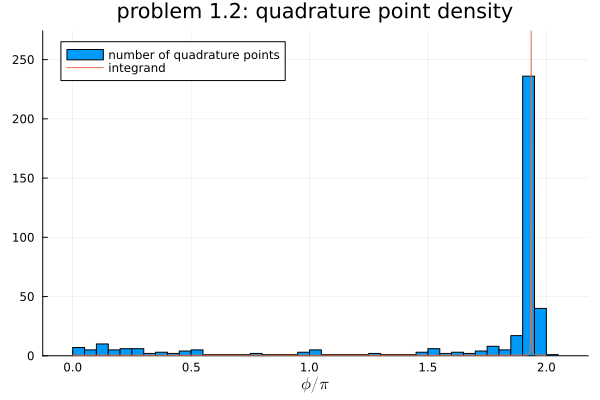

In [9]:
histogram(result.quadpts / π, title="problem 1.2: quadrature point density",
          xlabel=L"\phi / \pi", label="number of quadrature points")
plot!(ϕs/π, f1.(ϕs), label="integrand")

And you can see that it puts a lot more quadrature points around the peak.

**(3)** Now, we're going to repeat this, but with a new integrand $g_1(\phi) = 17.25 \cos(17.25 \phi)$, which is *not* periodic and for which the exact integral is $1$.

In [10]:
g1(ϕ) = 17.25 * cos(17.25ϕ)

errs2_padaptive = map(Npow2) do N
    x, w = clenshaw_curtis(N)
    ϕ = @. (x + 1) * π   # map the domain from [-1,1] to [0,2π]
    relerr(sum(g1.(ϕ) .* w) * π, 1)
end

errs2_trapz = map(Npow2) do N
    ϕ = range(0, 2π, length=N+1) # N+1 equally spaced points
    # note that f1(0) = f1(2π), so we can combine the first and last points
    relerr(sum(g1, ϕ[1:N]) * (2π/N), 1)
end

result2 = hadaptive(g1, 0, 2π, exact=1);

As above, let's plot it on *both* semilog and log–log scales:

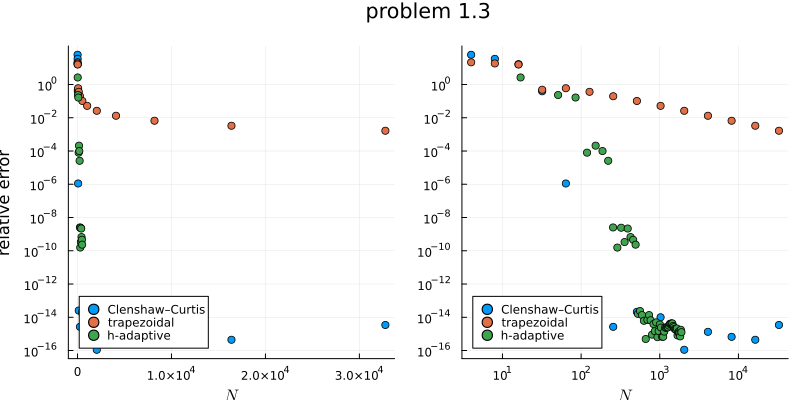

In [11]:
title = plot(title = "problem 1.3", 
             grid = false, showaxis = false, bottom_margin = -50Plots.px)

p2 = scatter(Npow2, errs2_padaptive, label="Clenshaw–Curtis", 
        yaxis=:log10, yticks=exp10.(-16:2:0),
        ylabel="relative error", xlabel=L"N", legend=:bottomleft)
scatter!(p2, Npow2, errs2_trapz, label="trapezoidal")
scatter!(p2, result2.evaluations, result2.errors / 2π, label="h-adaptive")

p1 = scatter(Npow2, errs2_padaptive, label="Clenshaw–Curtis", 
        xaxis=:log10, xticks=exp10.(0:5),
        yaxis=:log10, yticks=exp10.(-16:2:0),
        xlabel=L"N", legend=:bottomleft)
scatter!(p1, Npow2, errs2_trapz, label="trapezoidal")
scatter!(p1, result2.evaluations, result2.errors / 2π, label="h-adaptive")

plot(title, p2, p1, layout = @layout([A{0.1h}; [B C]]), size=(800,400))

What do we observe?

1. Since this function is not periodic, the trapezoidal rule is no longer exponentially convergent — it exhibits its typical $O(1/N^2)$ convergence rate.
2. Both p-adaptive Clenshaw–Curtis and h-adaptive quadrature *appear* exponential, although in the latter case this turns out to be an illusion as noted above.
3. h-adaptive quadrature has no particular advantage in this case, because the integrand "wiggles" at the same rate everywhere in the domain.  But it is still not too much worse than p-adaptive Clenshaw–Curtis!

The h-adaptive algorithm's convergence is quite robust: it is pretty good in lots of different cases.  That's why h-adaptive quadrature algorithms tend to be the "default" choice for 1d integration unless you know your integrand's behavior pretty well and can select a better quadrature algorithm to match.

# Problem 2: Monte-Carlo integration (10+10+10 points)


The volume of a unit $ n $-ball (a ball of radius 1 in $ n $-dimensional space) is given by the formula:

$$
V_n = \frac{\pi^{n/2}}{\Gamma\left(\frac{n}{2} + 1\right)}
$$


where $ \Gamma $ is the gamma function. For reference, the first few values are:

- $ V_1 = 2 $ (length of a line segment from $-1$ to $1$)
- $ V_2 = \pi $ (area of a circle with radius $1$)
- $V_3 = \frac{4\pi}{3}$ (volume of a sphere with radius $1$)
- $V_4 = \frac{\pi^2}{2}$
- $V_5 = \frac{8\pi^2}{15}$

The gamma function can be computed using [`scipy.special.gamma(z)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.gamma.html) in Python or [`SpecialFunctions.gamma(z)`](https://specialfunctions.juliamath.org/stable/functions_overview/) in Julia.

In [12]:
# Python:
# import numpy as np
# from scipy.special import gamma
# np.pi**(n/2) / gamma(n/2 + 1)

# Julia:
using SpecialFunctions
V(n) = π^(n/2) / gamma(n/2 + 1)

@show V(5)
@show 8π^2/15

V(5) = 5.263789013914325
(8 * π ^ 2) / 15 = 5.263789013914324


5.263789013914324

The Monte Carlo quadrature for integrating a function $ f(x) $ over a $ d $-dimensional hypercube $[-1, 1]^d$ can be computed as:

$$
\int_{[-1,1]^d} f(x) \,dx \approx \frac{2^d}{N} \sum_{i=1}^{N} f(x_i)
$$

where $ x_i $ are uniformly distributed random points in $[-1, 1]^d$ and $ 2^d $ is the volume of the hypercube.

**(1)** Write a function `monte_carlo_quadrature(f, N, d)` that returns the $N$-point Monte Carlo quadrature  of a function $f(x)$ over a $ d $-dimensional hypercube $[-1, 1]^d$, where the argument of $f$ is a $d$-component vector.   Note that the function `numpy.random.rand(d)` in Python and `rand(d)` in Julia both return a `d`-component vector uniformly distributed in $[0, 1]^d$ (not $[-1, 1]^d$); you can also generate many random points at once in a matrix with `rand(d, N)` or `rand(N, d)`, but be careful not to fill up all your memory when $N$ is large.   (To help you interpret your results, it might also be useful to compute and return the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation#Sample_standard_deviation) of the integrand at your $N$ points, which measures the spread around the mean, e.g. via `numpy.std` in Python or `Statistics.std` in Julia.)

As a check, use your function to estimate the volume of a unit $ n $-ball in dimensions $d = 1$ through $d = 3$, by integrating:

$$
f(x) :=
\begin{cases} 
   1, & \|x\|_2 < 1 \\
   0, & \|x\|_2 \ge 1
\end{cases}
$$
with $ N=100000 $ and check that the answer is roughly correct. This function can be implemented by (e.g.) `numpy.sum(x**2) < 1` in Python or `sum(x -> x^2, x) < 1` in Julia (or by using the `norm` functions in the respective linear-algebra modules).

**(2)** For each dimension $ d $ from 1 to 10, compute the relative error between your estimate and the true volume for various numbers of points $ N $, using logarithmically spaced values from $ N = 10 $ to $ N = 10^8 $.  Create a log-log plot showing the convergence rate (relative error vs. number of points) for all dimensions on the same graph.  Does it match the theoretical rate of $ O(N^{-1/2}) $ for Monte Carlo methods?

-----------

Next, we will consider the relative efficiency of Monte Carlo integration compared to deterministic quadrature methods for this problem.  Note that for piecewise smooth functions with discontinuities such as $ f(x) $ in Part 1, both the trapezoidal rule and Clenshaw–Curtis quadrature have an error of $ O(1/N_{1d}) $, where $ N_{1d} $ is the number of grid points in each dimension.  For smooth/analytic functions, from class, the trapezoidal rule converges as  $ O(1/N_{1d}^2) $ and Clenshaw–Curtis converges as  $ O(e^{-\alpha N_{1d}})$ for some $\alpha > 0$.

**(3)** For the discontinuous function $ f(x) $ in Part 1, what is the rate of convergence of the trapezoidal rule (or equivalently Clenshaw–Curtis) as a function of the total number of evaluations $ N $ and the dimension $ d $? How would the convergence rates change (for both trapezoidal rule and Clenshaw–Curtis) if the function were smooth (analytic)?   

### Solutions:

**(1)** We'll implement the Monte–Carlo integration in Julia, for performance.

We'll implement a straightforward loop, or equivalently a call to the `sum(1:N)` where we pass a function to sum (via the `do`) syntax and generate a random `x` on each loop iteration (no "vectorization" needed).   However, to avoid heap-allocating zillions of tiny arrays, we'll use one trick: we use the [StaticArrays.jl package](https://github.com/JuliaArrays/StaticArrays.jl) for the small $d$-dimensional arrays, encoding them in a `Val{d}` type so that the compiler specializes the function for each `d`:

In [13]:
using StaticArrays
function monte_carlo_quadrature(f, N, ::Val{d}) where {d}
    return sum(1:N) do _
        x = rand(SVector{d}) .* 2 .- 1
        f(x)
    end * 2^d / N
end
monte_carlo_quadrature(f, N, d::Integer) = monte_carlo_quadrature(f, N, Val(Int(d)))

# our integrand:
f2(x) = sum(x -> x^2, x) < 1

f2 (generic function with 1 method)

The most straightforward implementation in Python would be something like:
```py
def monte_carlo_quadrature(f, N, d):
    s = 0.0
    for i in range(N):
        x = numpy.random.rand(d) * 2 - 1
        s = s + f(x)
    return s * (2**d)/N
```
which is about 1000x slower than the Julia code above on my computer.  To make the Python version faster, we would ideally want to completely restructure the code to "vectorize" the function by not only generating a whole $n \times d$ matrix of random numbers at once, but also to "vectorize" our integrand `f` to act on the whole matrix at once.


Now, let's do the suggested "sanity check" for $N=100000$ and $d = 1$ to $d = 3$, comparing the relative error versus the exact volume:

In [14]:
relerr(val, exact) = abs(val - exact) / abs(exact)

relerr.(monte_carlo_quadrature.(f2, 10^5, 1:3), V.(1:3))

3-element Vector{Float64}:
 0.0
 0.0004861694619962178
 0.0023276899318687614

Not bad!  The relative error is **< 0.5% in all three cases**.

(In fact, for $d=1$, the relative error is zero!  That's because the 1-dimensional "sphere" fills up the entire $[-1,1]$ domain: `f2(x)` always returns `true`, so its variance is zero and Monte–Carlo integration is exact.)

**(2)** Now let's try plotting the relative error vs. $N$ as suggested.

(Performance really matters here!  If you did a straightforward implementation in Python, probably you won't be able to do so many points.  We'll use the `@time` macro in Julia to print out how much time it takes.)

In [15]:
Ns = round.(Int, exp10.(range(1, 8, length=200))) # log-spaced points from 10¹ to 10⁸
ds = 1:10

@time errs = relerr.(monte_carlo_quadrature.(f2, Ns, ds'), V.(ds'));

 93.316824 seconds (2.31 M allocations: 110.484 MiB, 0.01% gc time, 0.42% compilation time)


It took about 1.5 minutes on my computer (a 2022 Apple M1 Max).  If your code is a lot slower, you could compensate by doing fewer points (e.g. 40 points instead of 200) and only going up to $N = 10^7$.

Now, let's plot it, along with the expected $\sigma / \sqrt{N}$ convergence rates where $\sigma$ is the standard deviation of our integrand $2^d f(x)$, which we'll estimate with $10^8$ points. (You weren't required to do this, but it makes the plots easier to understand.)

In [16]:
using Statistics

function monte_carlo_variance(f, N, ::Val{d}) where {d}
    return std([let x = rand(SVector{d}) .* 2 .- 1
                    f(x)
                end for _=1:N]) * 2^d
end
monte_carlo_variance(f, N, d::Integer) = monte_carlo_variance(f, N, Val(Int(d)))

σ = monte_carlo_variance.(f2, 10^8, ds)

10-element Vector{Float64}:
  0.0
  1.6420928669192318
  3.9955531323583995
  7.389693653038426
 11.862647771213107
 17.436050479307113
 24.1388022461405
 31.961821865128435
 40.95171441668751
 50.91860848307324

As expected, the variance for $d = 1$ is zero, and after that it generally *increases* with dimension.  Moreover, for high dimensions, the sphere fills up a tinier and tinier fraction of the "box" volume:

In [17]:
V.(ds) ./ (2 .^ ds)

10-element Vector{Float64}:
 1.0
 0.7853981633974483
 0.5235987755982989
 0.30842513753404244
 0.16449340668482265
 0.08074551218828077
 0.03691223414321407
 0.0158543442438155
 0.006442400200661536
 0.00249039457019272

However, the relevant figure of merit for predicting the *relative* error is $\sigma / V$.  The fact that $\sigma$ is getting bigger and $V$ is getting smaller makes the problem of getting a lower *relative* error harder in high dimensions:

In [18]:
σ ./ V.(ds)

10-element Vector{Float64}:
  0.0
  0.5226943935722752
  0.9538680471017177
  1.4974650153602487
  2.2536328374589725
  3.3740362944742675
  5.108994265052958
  7.874867906274968
 12.415220217440027
 19.966797306702777

Now let's put it together and plot it:

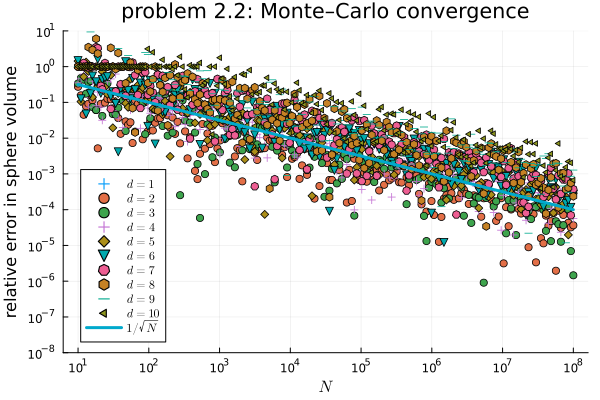

In [19]:
using Plots
scatter(Ns, errs .+ 1e-16, xaxis=:log10, yaxis=:log10, yticks=exp10.(-8:1), ylim=(1e-8, 10),
        xticks=exp10.(1:8),
        label=permutedims(string.("\$d= ", ds, "\$")), legend=:bottomleft,
        markers=permutedims(Plots.supported_markers()[1:10]),
        title="problem 2.2: Monte–Carlo convergence",
        ylabel="relative error in sphere volume", xlabel="\$N\$")
plot!(Ns, 1 ./ sqrt.(Ns), label="\$ 1 / \\sqrt{N} \$", linewidth=3)

As expected, they all converge as $\sim 1/\sqrt{N}$, with the exception of $d=1$ where the error is always zero.

It's a bit hard to distinguish the different dimensions with them all plotted together like this.  Let's also plot a subset $d \in \{3,6,8,10\}$ individually, for example.  For each one, we'll also plot the theoretical convergence rate $\sigma / V$, where $\sigma$ is the standard deviation (spread from the mean) of our function $f(x)$.

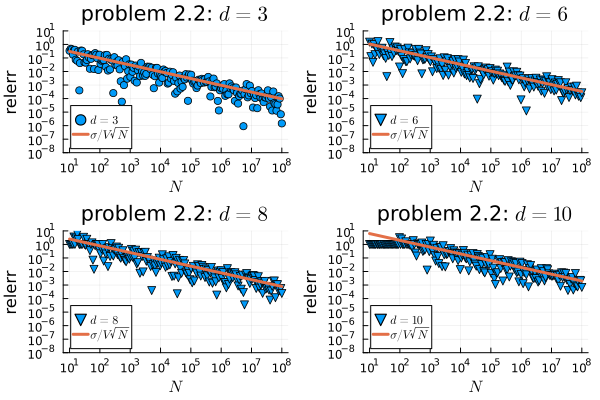

In [20]:
p3 = scatter(Ns, errs[:,3] .+ 1e-16, xaxis=:log10, yaxis=:log10, yticks=exp10.(-8:1), ylim=(1e-8, 10),
        xticks=exp10.(1:8),
        label="\$d = 3\$", legend=:bottomleft,
        markers=Plots.supported_markers()[3],
        title="problem 2.2: \$d = 3\$",
        ylabel="relerr", xlabel="\$N\$")
plot!(p3, Ns, (σ[3]/V(3)) ./ sqrt.(Ns), label=L"\sigma / V \sqrt{N}", linewidth=3)

p6 = scatter(Ns, errs[:,6] .+ 1e-16, xaxis=:log10, yaxis=:log10, yticks=exp10.(-8:1), ylim=(1e-8, 10),
        xticks=exp10.(1:8),
        label="\$d = 6\$", legend=:bottomleft,
        markers=Plots.supported_markers()[6],
        title="problem 2.2: \$d = 6\$",
        ylabel="relerr", xlabel="\$N\$")
plot!(p6, Ns, (σ[6]/V(6)) ./ sqrt.(Ns), label=L"\sigma / V \sqrt{N}", linewidth=3)

p8 = scatter(Ns, errs[:,8] .+ 1e-16, xaxis=:log10, yaxis=:log10, yticks=exp10.(-8:1), ylim=(1e-8, 10),
        xticks=exp10.(1:8),
        label="\$d = 8\$", legend=:bottomleft,
        markers=Plots.supported_markers()[6],
        title="problem 2.2: \$d = 8\$",
        ylabel="relerr", xlabel="\$N\$")
plot!(p8, Ns, (σ[8]/V(8)) ./ sqrt.(Ns), label=L"\sigma / V \sqrt{N}", linewidth=3)

p10 = scatter(Ns, errs[:,10] .+ 1e-16, xaxis=:log10, yaxis=:log10, yticks=exp10.(-8:1), ylim=(1e-8, 10),
        xticks=exp10.(1:8),
        label="\$d = 10\$", legend=:bottomleft,
        markers=Plots.supported_markers()[6],
        title="problem 2.2: \$d = 10\$",
        ylabel="relerr", xlabel="\$N\$")
plot!(p10, Ns, (σ[10]/V(10)) ./ sqrt.(Ns), label=L"\sigma  / V \sqrt{N}", linewidth=3)

plot(p3, p6, p8, p10)

Even though the variance gets smaller for bigger $d$, the *relative* error gets larger because we are trying to "find" a smaller volume in the box — finding a needle in a haystack for large $d$.  For large $d$, you need a sufficiently large $N$ for the error to start improving *at all*, because until that point the random samples don't "find" the sphere.  And the theory (red line) is indeed a very good match for the observed values.

**(3)** If we have $N_{1d}$ points along each dimension, then the total number of points is $N = N_{1d}^d$, or equivalently $N_{1d} = N^{1/d}$.  That means that for a discontinuous integrand where you have first-order convergence (with either trapezoidal or Clenshaw–Curtis), the convergence is $O(N_{1d}^{-1}) = \boxed{O(N^{-1/d})}$.   This is *worse* than Monte-Carlo for $d > 2$!

For a *smooth* integrand, trapezoidal rule converges generically as $O(N_{1d}^{-2}) = \boxed{O(N^{-2/d})}$, which is worse than Monte–Carlo for $d > 4$.


For a *smooth* integrand, Clenshaw–Curtis converges generically as $O(e^{-\alpha N_{1d}}) = \boxed{O(e^{-\alpha N^{1/d}})}$, which is *asymptotically* always better than Monte–Carlo for any dimensions!  However, in *practice* you may never reach this asymptotic regime in high dimensions — for $d = 10$, even having 10 points along each dimension is $10^{10}$ points.

This is the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

## Problem 3: Newton methods (10+10+10 points)

**(1)** The [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function) is a root $w$ of the function $f(w) = w e^w - z = 0$, which implicitly defines a function $w(z)$.   Use Newton's method to compute and plot $w(z)$ for a set of 100 points $z \in [0,1]$, starting with an initial guess $w = z$.   Check your answer against [`scipy.special.lambertw(z)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.lambertw.html) in Python or [`LambertW.lambertw(z)`](https://github.com/robertdj/LambertW.jl) in Julia.

**(2)** Propose a Newton-like iteration $x_k \to x_{k+1}$ to find a root of any $f(x) = 0$ (not just Lambert W) that takes advantage of $f, f', f''$ at $x_k$ by making a *quadatic* approximation rather than a linear approximation.  (A quadratic approximation has two roots; which should you pick?  If you solve a quadratic equation $ax^2 + bx + c = 0$, you might want to compute the two roots as $\frac{-b - \sqrt{b^2 - 4ac}}{2a}$ and $\frac{2c}{-b - \sqrt{b^2 - 4ac}}$, assuming $b > 0$, to avoid disastrous cancellation errors for $|ac| \ll b^2$ as [discussed in class](https://github.com/mitmath/numerical_hub/blob/dd24729ecb3340b6551b1aaeb18afafdd5135fad/notes/Floating-Point-Intro.ipynb).)

**(3)** Apply your algorithm (2) to find a root of $\sin(x)$ starting from $x=3$, which *should* converge to $\pi$.   Give convincing numerical evidence that it is converging *cubically*: if $\epsilon_k$ is the error on step $k$, then the error on the next step is $O(\epsilon_k^3)$.  You may need to use arbitrary-precision arithmetic (via the `mpmath` package in Python or using `BigFloat` numbers in Julia) to see this clearly.

### Solutions:

**(1)** Let's begin by writing a Newton solver.  To avoid having to supply derivatives manually, we'll "cheat" and use the [ForwardDiff.jl automatic differentiation (AD) package](https://github.com/JuliaDiff/ForwardDiff.jl) in Julia.

In [21]:
import ForwardDiff

# solve f(x) = 0, with initial guess x₀
function newton(f, x₀; rtol=1e-8, atol=0)
    x = float(x₀)
    while true
        δx = f(x) / ForwardDiff.derivative(f, x)
        x -= δx
        abs(δx) ≤ max(atol, rtol * abs(x)) && return x # converged
    end
end

# sanity check: try to find a root of sin(x) starting at x₀=3, should give π:
newton(sin, 3) - π

0.0

Great, this seems to work!  Now let's try it on the Lambert W function, and compare to the LambertW.jl package in Julia:

In [22]:
using LambertW

z = range(0,1,length=100)
w = [newton(w -> w * exp(w) - z, z) for z in z]
wexact = lambertw.(z)

println(relerr.(w, wexact))

[NaN, 1.7346370239081224e-16, 1.7517293912923572e-16, 0.0, 1.7854341168842083e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3756490886412634e-16, 1.111823992983239e-16, 2.0917977611251645e-16, 1.9763232083518414e-16, 0.0, 0.0, 0.0, 1.6291001321756234e-16, 0.0, 0.0, 0.0, 1.3966333484564157e-16, 0.0, 1.306909856531965e-16, 0.0, 1.2298222010873752e-16, 1.1952023344674693e-16, 0.0, 1.13254909101373e-16, 0.0, 2.1547046900489767e-16, 2.1042814332821946e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6668335541225554e-16, 1.6402112210453722e-16, 0.0, 0.0, 1.5665357942100337e-16, 0.0, 0.0, 0.0, 0.0, 1.4610342955132365e-16, 0.0, 0.0, 1.4061592156508931e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1444092555920316e-16, 0.0, 1.1251178036017587e-16, 1.115810210988308e-16, 0.0, 0.0, 0.0, 2.1613037114531027e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9832915939159824e-16, 0.0, 0.0]


Great, the relative error looks consistently small compared to `lambertw`.  Note that the first error in the list is `NaN` because in that case both values are zero, so we have 0/0.  More quantitatively, the maximum relative error (excluding the NaN) is:

In [23]:
maximum(relerr.(w, wexact)[2:end])

2.3756490886412634e-16

So we are getting the right answer (assuming LambertW.jl is correct) to essentially machine precision.

Let's plot it:

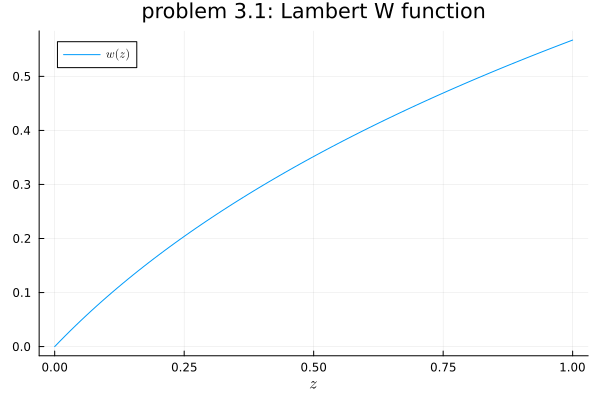

In [24]:
plot(z, w, title="problem 3.1: Lambert W function", xlabel=L"z", label=L"w(z)")

**(2)**  We approximate $f(x)$ by the first two terms in the Taylor series (assuming $f$ is analytic):
$$
f(x - \delta) \approx f(x) - \delta f'(x) + \frac{\delta^2}{2} f''(x) = 0
$$
and set the right-hand side to zero to find an approximate root.  Solving the quadratic equation and eliding the $(x)$ arguments, we obtain an approximate step to the root:
$$
\delta = \frac{f' \pm \sqrt{f'^2 - 2ff''}}{f''}
$$
Close to the root, $f$ is small and therefore the discriminant will be positive and we will get real roots.   Say $f' > 0$.  Then we want the minus root of this quadratic, because we want the *nearest* root (the smallest $\delta$): that is where the quadratic approximation is most accurate.  But this will run into cancellation errors for subtracting two nearly equal quantities, so we rewrite the desired solution (as in class) as:
$$
\delta = \frac{2f}{f' + \sqrt{f'^2 - 2ff''}}
$$
Conversely, if $f' < 0$, then we need the other root $2f / (f' - \sqrt{f'^2 - 2ff''})$.  That is, we want to copy the sign of $f'$ to the square root, which is easily done with the Julia `copysign` function.

If we are not close to the root, so that the discriminant is negative, we will just take an ordinary Newton step $\delta = f/f'$.  Notice that this is also approximately the step we take when $f$ is very small.  In general, just like any Newton method, **we'll need a sufficiently good initial guess to get convergence.**

(A variant of this idea, that replaces $f(x)$ by $f/\sqrt{|f(x)|}$ to avoid having to take square roots, is known as [Halley’s method](https://en.wikipedia.org/wiki/Halley%27s_method))

**(3)** Here is code that implements this idea.  Again, we will use ForwardDiff to take the derivatives for us.  So that we can explicitly plot the convergence, we'll pass in the number of steps `n` as a parameter, rather than using a convergence test:

In [25]:
# take n Newtonish steps starting at x, given functions f(x),
# and taking its derivatives f′(x),f″(x) using AD
function newtonish(f, x, n)
    f′(x) = ForwardDiff.derivative(f, x)
    f″(x) = ForwardDiff.derivative(f′, x) # 2nd derivative by nesting AD!
    for i = 1:n
        fx = f(x)
        f′x = f′(x)
        f″x = f″(x)
        discrim = f′x^2 - 2*fx*f″x
        δ = discrim < 0 ? fx/f′x : 2fx / (f′x + copysign(sqrt(discrim), f′x))
        x = x - δ
    end
    return x
end

newtonish (generic function with 1 method)

Now, we will apply it to find $\pi$ by searching for a root of $\sin(x) = 0$ starting at $x=3$.

This method *should* converge so fast that we will have a difficult time seeing the convergence unless we go to many digits, much higher than double precision.  We will do so using Julia's `BigFloat` type (or in Python you could use `mpmath`), which implements [arbitrary precision arithmetic](https://en.wikipedia.org/wiki/Arbitrary-precision_arithmetic), setting our precision to **≈ 10,000 decimal digits**.

Here, a key factor is that our `newtonish` code above is **"type-generic"** — it works for *any* numeric type, and in particular it does all its computations in a precision determined by the initial guess `x`.  So, we can just pass `x = big"3.0"` to use `BigFloat` precision.

(Note that Julia's built-in `π` constant is "adaptively" computed in the precision of whatever it is combined with in operations, and we can explicitly get `π` to the current `BigFloat` precision by typing `big(π)`.)

In [26]:
log10_err_π = setprecision(10000, base=10) do # use about 10,000 decimal digits of precision
    map(1:8) do n
        # return log₁₀ |relative error| after n steps
        Float64(log10(abs(newtonish(sin, big(3.0), n) - π) / π))
    end
end

8-element Vector{Float64}:
    -3.829091883961742
   -11.271127232214466
   -33.59723320163877
  -100.5755511099117
  -301.51050483473045
  -904.3153660091867
 -2712.7299495325556
 -8137.973700102662

We can see that the $\log_{10} |\text{error}|$ decreases *very* rapidly — after only 8 steps it is ≈ -8000, or more than 8000 accurate decimal digits! 

Let $\epsilon_k$ be the error after the $k$-th step, similar to how we analyzed Newton methods in class.  The suggestion in this problem is that $\epsilon_{k+1} = O(\epsilon_k^3)$, i.e. cubic convergence.  How would we check this?

Just "eyeballing" the numbers printed out above, you should notice that $\log_{10} \epsilon_k$ **roughly triples** on each step, which is consistent with **cubing the error** on each step.

To be more quantitative, a natural thing to do would be to plot $\epsilon_{k+1}$ vs. $\epsilon_k$ on a log–log scale.  If it is a power law, this should be a straight line, and the slope should tell us whether it is linear, quadratic, cubic, etcetera:

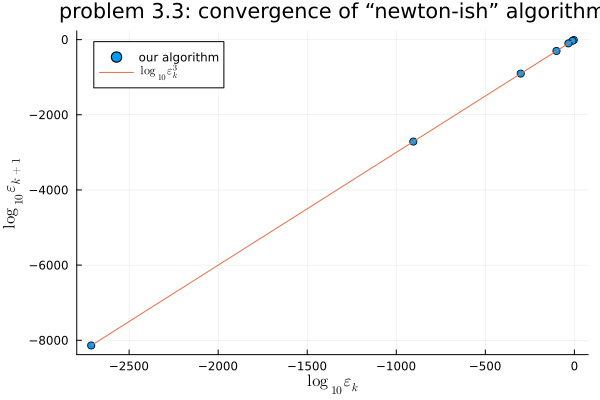

In [27]:
scatter(log10_err_π[1:end-1], log10_err_π[2:end], label="our algorithm",
        title="problem 3.3: convergence of “newton-ish” algorithm",
        xlabel=L"\log_{10} \epsilon_k", ylabel=L"\log_{10} \epsilon_{k+1}")
plot!(log10_err_π[1:end-1], 3 .* log10_err_π[1:end-1], label=L"\log_{10} \epsilon_k^3")

Wow, a perfect fit — it really is **cubic convergence**!

The intuition here is that if you do a linear fit as in Newton's method, you cancel the linear terms in $\epsilon_k$ and are left with the quadratic terms.  If you do a quadratic fit as in the method of this problem, you cancel the linear and quadratic terms in $\epsilon_k$ and are left with the cubic term.

Another way to see the cubic convergence clearly, which *doesn't* require arbitrary precision, is to simply plot the error $|\epsilon_1|$ after **one step** of the method, starting at $\pi + \epsilon_0$, as a function of $\epsilon_0$ on a log-log scale.

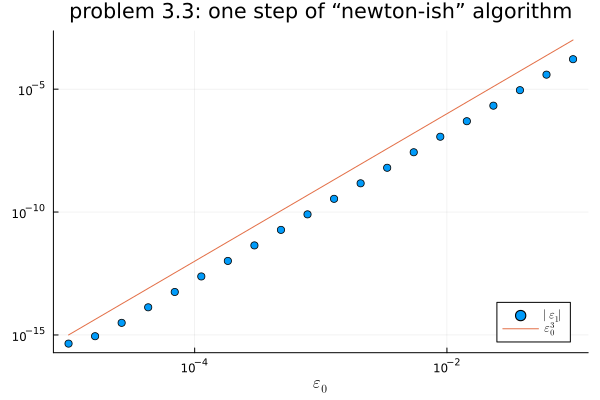

In [30]:
ϵ₀ = exp10.(range(-1, -5, length=20))
ϵ₁ = @. newtonish(sin, π + ϵ₀, 1) - π
scatter(ϵ₀, abs.(ϵ₁), label=L"|\epsilon_1|", xlabel=L"\epsilon_0", yaxis=:log10, xaxis=:log10)
plot!(ϵ₀, ϵ₀ .^ 3, label=L"\epsilon_0^3")
plot!(title="problem 3.3: one step of “newton-ish” algorithm", legend=:bottomright)

This is even more clear than the previous plot, since we can pick as many $\epsilon_0$ values as we want: **cubic convergence**, again!